## Libraries
- rasterio: used for reading and writing geospacial raster data (jp2 files)

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# defining the data paths for our different bands to visualize
base_path = 'sentinel2/S2B_MSIL2A_20250811T102559_N0511_R108_T32UMV_20250811T131147.SAFE/GRANULE/L2A_T32UMV_A044035_20250811T103624/IMG_DATA/R10m'
# we will use band 2 (blue),3(green),4(red),8(NIR)
band2_path = 'T32UMV_20250811T102559_B02_10m.jp2'
band3_path = 'T32UMV_20250811T102559_B03_10m.jp2'
band4_path = 'T32UMV_20250811T102559_B04_10m.jp2'
band8_path = 'T32UMV_20250811T102559_B08_10m.jp2'

In [3]:
# loading the bands into memory
with rasterio.open(os.path.join(base_path, band2_path)) as src:
    blue = src.read(1)

with rasterio.open(os.path.join(base_path, band3_path)) as src:
    green = src.read(1)

with rasterio.open(os.path.join(base_path, band4_path)) as src:
    red = src.read(1)
    
with rasterio.open(os.path.join(base_path, band8_path)) as src:
    nir = src.read(1)

In [4]:
# checking the shape of the bands
print('Shape of blue band: ', blue.shape, ' Min value: ', np.min(blue), ' Max value: ', np.max(blue))
print('Shape of green band: ', green.shape, ' Min value: ', np.min(green), ' Max value: ', np.max(green))
print('Shape of red band: ', red.shape, ' Min value: ', np.min(red), ' Max value: ', np.max(red))
print('Shape of NIR band: ', nir.shape, ' Min value: ', np.min(nir), ' Max value: ', np.max(nir))

Shape of blue band:  (10980, 10980)  Min value:  0  Max value:  18704
Shape of green band:  (10980, 10980)  Min value:  0  Max value:  17840
Shape of red band:  (10980, 10980)  Min value:  0  Max value:  17232
Shape of NIR band:  (10980, 10980)  Min value:  0  Max value:  16578


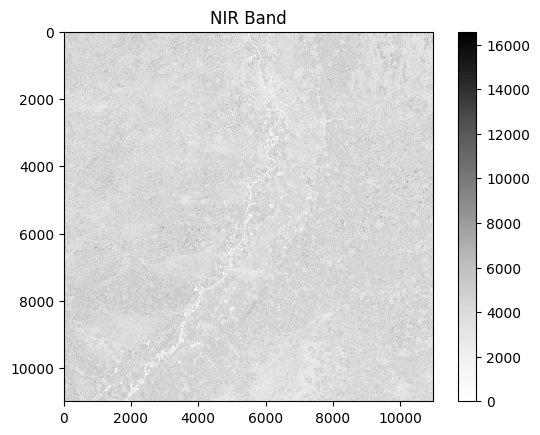

In [5]:
# visualizing the NIR band
plt.imshow(nir, cmap='Grays')
plt.colorbar()
plt.title("NIR Band")
plt.show()

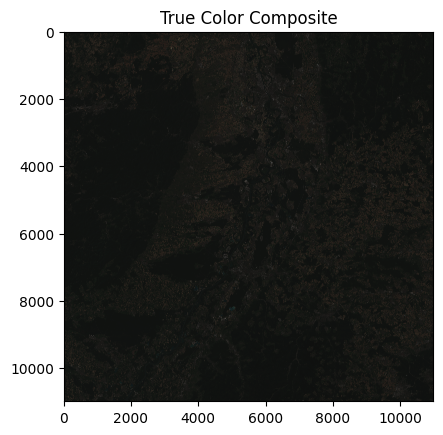

In [6]:
# visualizing the RGB image from the three visible light bands
rgb = np.dstack((red, 
                 green, 
                 blue))
## plt expects data between [0,1] or [0,255] but our range is much higher (as seen in the cells above) so we need to normalize it
rgb_norm = rgb / np.max(rgb)
# rgb_norm = (rgb_norm * 255).astype(np.int32)

plt.imshow(rgb_norm)
plt.title("True Color Composite")
plt.show()

In [7]:
## sentinel 2's data is stored as scaled integers (scaling factor of 10000)
## values above 10000 should not exist but exist due to sensor saturation or atmospheric correction

# fix the scale
red = red.astype('float32') / 10000
green = green.astype('float32') / 10000
blue = blue.astype('float32') / 10000
nir = nir.astype('float32') / 10000

# Clip values to [0, 1] to remove unrealistic extremes
red = np.clip(red, 0, 1)
green = np.clip(green, 0, 1)
blue = np.clip(blue, 0, 1)
nir = np.clip(nir, 0, 1)

/tmp/ipykernel_5088/1900337258.py:2: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


-0.5601841 0.8313485


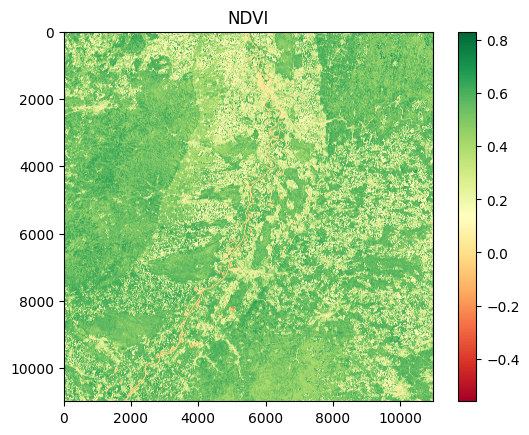

In [8]:
## NDVI: Normalized difference vegetation index - higher the value, the better the vegetation health
ndvi = (nir - red) / (nir + red)
ndvi = np.nan_to_num(ndvi, nan=0.0, posinf=0.0, neginf=0.0)
print(np.min(ndvi), np.max(ndvi))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title("NDVI")
plt.show()

/tmp/ipykernel_5088/435273666.py:2: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - nir) / (nir + green)


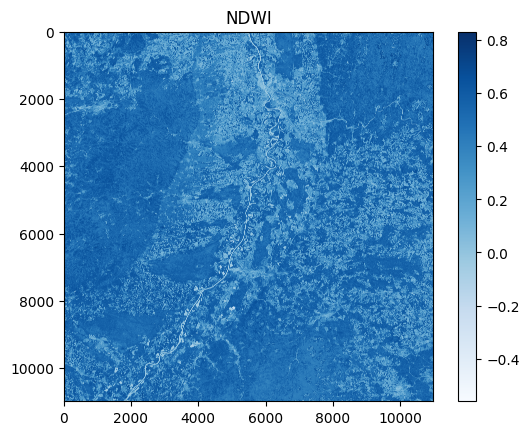

In [9]:
## NDWI: Normalized Difference Water Index - the higher the value, the more chances that it is water
ndwi = (green - nir) / (nir + green)
ndwi = np.nan_to_num(ndwi, nan=0.0, posinf=0.0, neginf=0.0)
plt.imshow(ndvi, cmap='Blues')
plt.colorbar()
plt.title("NDWI")
plt.show()

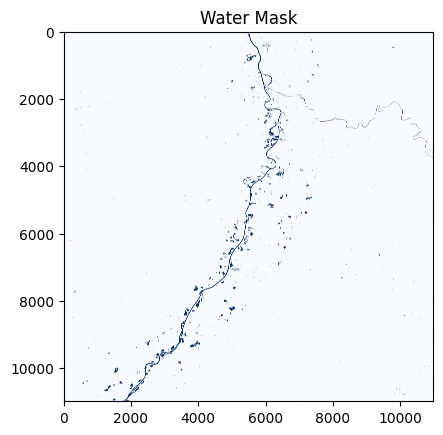

In [10]:
water_mask = ndwi > 0.0

plt.imshow(water_mask, cmap='Blues')
plt.title("Water Mask")
plt.show()

In [11]:
base_path = 'sentinel2'
all_snippets = os.listdir(base_path)
print('Total data snippets: ', len(all_snippets))

Total data snippets:  5


## Checking the thresholds (visually) for water mask for all data snippets. We will use this as ground truth for segmentation

for  S2A_MSIL2A_20250629T102701_N0511_R108_T32UMV_20250629T143707.SAFE
Shape of green band:  (10980, 10980)  Min value:  342  Max value:  17920
Shape of NIR band:  (10980, 10980)  Min value:  0  Max value:  16609


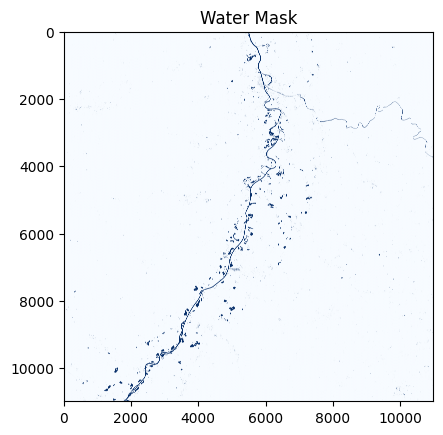

In [12]:
data_path = os.path.join(base_path, all_snippets[0], 'GRANULE')
_ = os.listdir(data_path)
data_path = os.path.join(data_path, _[0], 'IMG_DATA/R10m')
band3_path = [i for i in os.listdir(data_path) if 'B03' in i][0]
band8_path = [i for i in os.listdir(data_path) if 'B08' in i][0]
with rasterio.open(os.path.join(data_path, band3_path)) as src:
    green = src.read(1)
with rasterio.open(os.path.join(data_path, band8_path)) as src:
    nir = src.read(1)
print('for ', all_snippets[0])
print('Shape of green band: ', green.shape, ' Min value: ', np.min(green), ' Max value: ', np.max(green))
print('Shape of NIR band: ', nir.shape, ' Min value: ', np.min(nir), ' Max value: ', np.max(nir))

# scaling
green = green.astype('float32') / 10000
nir = nir.astype('float32') / 10000

# Clip values 
green = np.clip(green, 0, 1)
nir = np.clip(nir, 0, 1)

# ndwi calculation
ndwi = (green - nir) / (nir + green)
ndwi = np.nan_to_num(ndwi, nan=0.0, posinf=0.0, neginf=0.0)
water_mask = ndwi > 0.0

plt.imshow(water_mask, cmap='Blues')
plt.title("Water Mask")
plt.show()

for  S2A_MSIL2A_20250818T103041_N0511_R108_T32UMV_20250818T143613.SAFE
Shape of green band:  (10980, 10980)  Min value:  0  Max value:  17840
Shape of NIR band:  (10980, 10980)  Min value:  0  Max value:  16592


/tmp/ipykernel_5088/2640623194.py:23: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - nir) / (nir + green)


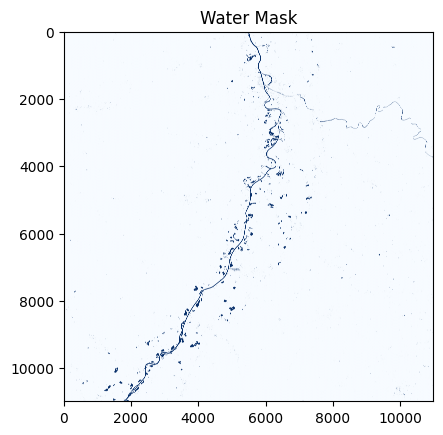

In [13]:
data_path = os.path.join(base_path, all_snippets[1], 'GRANULE')
_ = os.listdir(data_path)
data_path = os.path.join(data_path, _[0], 'IMG_DATA/R10m')
band3_path = [i for i in os.listdir(data_path) if 'B03' in i][0]
band8_path = [i for i in os.listdir(data_path) if 'B08' in i][0]
with rasterio.open(os.path.join(data_path, band3_path)) as src:
    green = src.read(1)
with rasterio.open(os.path.join(data_path, band8_path)) as src:
    nir = src.read(1)
print('for ', all_snippets[1])
print('Shape of green band: ', green.shape, ' Min value: ', np.min(green), ' Max value: ', np.max(green))
print('Shape of NIR band: ', nir.shape, ' Min value: ', np.min(nir), ' Max value: ', np.max(nir))

# scaling
green = green.astype('float32') / 10000
nir = nir.astype('float32') / 10000

# Clip values 
green = np.clip(green, 0, 1)
nir = np.clip(nir, 0, 1)

# ndwi calculation
ndwi = (green - nir) / (nir + green)
ndwi = np.nan_to_num(ndwi, nan=0.0, posinf=0.0, neginf=0.0)
water_mask = ndwi > 0.0

plt.imshow(water_mask, cmap='Blues')
plt.title("Water Mask")
plt.show()

for  S2B_MSIL2A_20250702T102559_N0511_R108_T32UMV_20250702T124602.SAFE
Shape of green band:  (10980, 10980)  Min value:  0  Max value:  18528
Shape of NIR band:  (10980, 10980)  Min value:  0  Max value:  16898


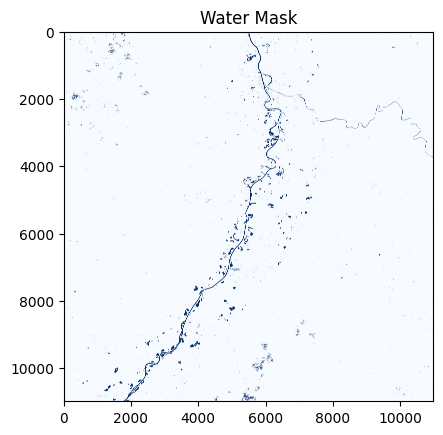

In [14]:
data_path = os.path.join(base_path, all_snippets[2], 'GRANULE')
_ = os.listdir(data_path)
data_path = os.path.join(data_path, _[0], 'IMG_DATA/R10m')
band3_path = [i for i in os.listdir(data_path) if 'B03' in i][0]
band8_path = [i for i in os.listdir(data_path) if 'B08' in i][0]
with rasterio.open(os.path.join(data_path, band3_path)) as src:
    green = src.read(1)
with rasterio.open(os.path.join(data_path, band8_path)) as src:
    nir = src.read(1)
print('for ', all_snippets[2])
print('Shape of green band: ', green.shape, ' Min value: ', np.min(green), ' Max value: ', np.max(green))
print('Shape of NIR band: ', nir.shape, ' Min value: ', np.min(nir), ' Max value: ', np.max(nir))

# scaling
green = green.astype('float32') / 10000
nir = nir.astype('float32') / 10000

# Clip values 
green = np.clip(green, 0, 1)
nir = np.clip(nir, 0, 1)

# ndwi calculation
ndwi = (green - nir) / (nir + green)
ndwi = np.nan_to_num(ndwi, nan=0.0, posinf=0.0, neginf=0.0)
water_mask = ndwi > 0.0

plt.imshow(water_mask, cmap='Blues')
plt.title("Water Mask")
plt.show()

for  S2B_MSIL2A_20250811T102559_N0511_R108_T32UMV_20250811T131147.SAFE
Shape of green band:  (10980, 10980)  Min value:  0  Max value:  17840
Shape of NIR band:  (10980, 10980)  Min value:  0  Max value:  16578


/tmp/ipykernel_5088/2047097269.py:23: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - nir) / (nir + green)


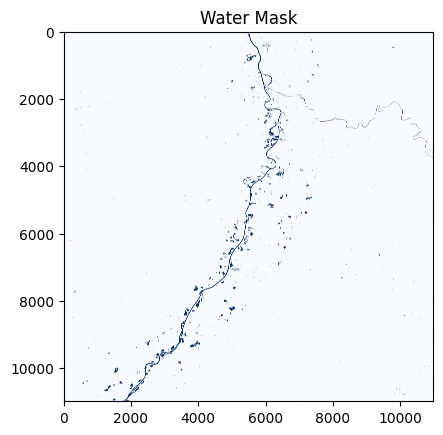

In [15]:
data_path = os.path.join(base_path, all_snippets[3], 'GRANULE')
_ = os.listdir(data_path)
data_path = os.path.join(data_path, _[0], 'IMG_DATA/R10m')
band3_path = [i for i in os.listdir(data_path) if 'B03' in i][0]
band8_path = [i for i in os.listdir(data_path) if 'B08' in i][0]
with rasterio.open(os.path.join(data_path, band3_path)) as src:
    green = src.read(1)
with rasterio.open(os.path.join(data_path, band8_path)) as src:
    nir = src.read(1)
print('for ', all_snippets[3])
print('Shape of green band: ', green.shape, ' Min value: ', np.min(green), ' Max value: ', np.max(green))
print('Shape of NIR band: ', nir.shape, ' Min value: ', np.min(nir), ' Max value: ', np.max(nir))

# scaling
green = green.astype('float32') / 10000
nir = nir.astype('float32') / 10000

# Clip values 
green = np.clip(green, 0, 1)
nir = np.clip(nir, 0, 1)

# ndwi calculation
ndwi = (green - nir) / (nir + green)
ndwi = np.nan_to_num(ndwi, nan=0.0, posinf=0.0, neginf=0.0)
water_mask = ndwi > 0.0

plt.imshow(water_mask, cmap='Blues')
plt.title("Water Mask")
plt.show()

for  S2C_MSIL2A_20250319T102801_N0511_R108_T32UMV_20250319T154921.SAFE
Shape of green band:  (10980, 10980)  Min value:  0  Max value:  17856
Shape of NIR band:  (10980, 10980)  Min value:  0  Max value:  16672


/tmp/ipykernel_5088/2352225022.py:23: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - nir) / (nir + green)


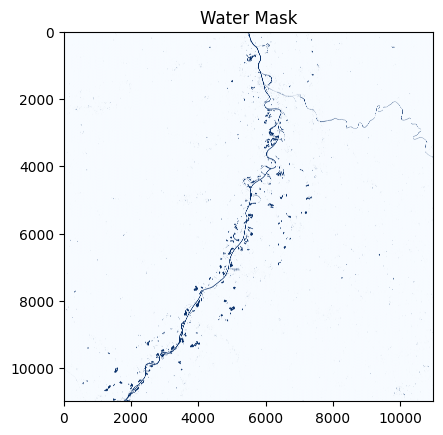

In [16]:
data_path = os.path.join(base_path, all_snippets[4], 'GRANULE')
_ = os.listdir(data_path)
data_path = os.path.join(data_path, _[0], 'IMG_DATA/R10m')
band3_path = [i for i in os.listdir(data_path) if 'B03' in i][0]
band8_path = [i for i in os.listdir(data_path) if 'B08' in i][0]
with rasterio.open(os.path.join(data_path, band3_path)) as src:
    green = src.read(1)
with rasterio.open(os.path.join(data_path, band8_path)) as src:
    nir = src.read(1)
print('for ', all_snippets[4])
print('Shape of green band: ', green.shape, ' Min value: ', np.min(green), ' Max value: ', np.max(green))
print('Shape of NIR band: ', nir.shape, ' Min value: ', np.min(nir), ' Max value: ', np.max(nir))

# scaling
green = green.astype('float32') / 10000
nir = nir.astype('float32') / 10000

# Clip values 
green = np.clip(green, 0, 1)
nir = np.clip(nir, 0, 1)

# ndwi calculation
ndwi = (green - nir) / (nir + green)
ndwi = np.nan_to_num(ndwi, nan=0.0, posinf=0.0, neginf=0.0)
water_mask = ndwi > 0.0

plt.imshow(water_mask, cmap='Blues')
plt.title("Water Mask")
plt.show()

## The threshold of 0.0 seems to be working fine in this case